# 1. Imports

In [1]:
# our functions
import functions as f

# readers

import gzip
import json

import codecs

import numpy as np

import random

# plot
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import accuracy_score

# NN
## early stopping
import h5py
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# time
from datetime import datetime

# preprocessing
import re
from keras.preprocessing.text import Tokenizer
from collections import defaultdict

# spelling correction
import pkg_resources
from symspellpy.symspellpy import SymSpell, Verbosity

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
# term_index is the column of the term and count_index is the
# column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

# NN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
PATH = {}
PATH["dataset_classification"] = "dataset/classification/"
PATH["dataset_labeling"] = "dataset/seq_labeling/"
PATH["music_reviews_train"] = PATH["dataset_classification"] + "music_reviews_train.json.gz"
PATH["music_reviews_dev"] = PATH["dataset_classification"] + "music_reviews_dev.json.gz"
PATH["music_reviews_test"] = PATH["dataset_classification"] + "music_reviews_test_masked.json.gz"

# sent dict
sent_dict = {"positive": 1, "negative": 0}

# 2. Read in the files

In [3]:
train = f.readJson(PATH["music_reviews_train"])
dev = f.readJson(PATH["music_reviews_dev"])
test = f.readJson(PATH["music_reviews_test"])
length_of_sentencies_counter = []

Number of data:  100000
Number of data:  10000
Number of data:  10000


## Corpus Decreasing

## 1 BASIC PREPROCESSING

In [4]:
# we need to delete punctuations and some stop words
import string

def remove_stop_words(text):
    my_stop_words = ['$',"'","``","''","'s"]
    whitespace = [' ', '\t', '\n', '\r', '\x0b', '\x0c']
    punct = ['"','#','$','%', '&', "'",'(', ')', '*', '+', ',', '-', '/', ':', ';', '<', '=', '>', '@', '[', '\\',
             ']', '^', '_', '`', '{', '|', '}', '~'] # ? ! . are deleted
    
    stop_words_be = ['heee','i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
    'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
    'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
    'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
    'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
    'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
    'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
    'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
    'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
    'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
    'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
    'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', '\n', 'the', '\x1bthis']

    stop_words = set(list(my_stop_words) + list(string.digits) + punct + stop_words_be)
    clean_text = []
    length_of_sentencies_counter = []
    
    for sent in text:
        # add whitespaces between punctuations, etc to be able to remove them
        sent = re.sub('(?<! )(?=[.,!?()~${}"|#&%*@\'^+-/_0123456789:>`<;=\[\]])|(?<=[.,!?()~${}"|#&%*@\'^+-/_0123456789:>`<;=\[\]])(?! )', r' ', sent)
        d_sent = []
        for c in sent.split():
            if c in stop_words:
                None
            else:
                d_sent.append(c)
        clean_text.append(list(d_sent))
        length_of_sentencies_counter.append(len(d_sent))
        #print(d_sent)
    return clean_text,length_of_sentencies_counter #length_of_sentencies_counter

## 2. Check for words which are non-english ones

In [5]:
# pretokenizing for basic corpus
pre_tokenizer = Tokenizer( #keras
    num_words=None, # maximum number of words - most common ones
    filters=None, #punctiations, etc
    lower=True,
    split=' ',
    char_level=False, #its not working, anyway
    oov_token=False,
    document_count=0,
)

In [6]:
def unknown_words_to_words(dictionary):
    unk_words_dict = defaultdict(str)
    for word in dictionary:
        if word in ['!','?','.']: # keep the basic puntuations
            unk_words_dict[word] = word
        else:
            suggestions = sym_spell.lookup(word, Verbosity.CLOSEST,max_edit_distance=2)
        # first finding
            #print(word)
            if len(suggestions) == 0: # if there is no suggestion, or totally fucked word
                None
            else:
                unk_words_dict[word] = suggestions[0].term
    return unk_words_dict

In [17]:
word = "loool"
suggestions = sym_spell.lookup(word, Verbosity.CLOSEST,max_edit_distance=2)
suggestions[0].term

'local'

# CREATE A TOKENIZER WITH CORPUS LIMITATION BASED ON THE TRAIN SET

In [7]:
# read the train data
data = train
train_sent = []
train_sentiment = []
train_idx = []
missing_indexies = []
y_train = []
length_of_sentencies_counter = []
for i in range(len(data)):
    try:
        train_sent.append(data[i]["reviewText"])
        train_sentiment.append(data[i]["sentiment"])
        train_idx.append(i)
        y_train.append(sent_dict[data[i]["sentiment"]])
        #length_of_sentencies_counter.append(len(data[i]["reviewText"].split()))
    except KeyError:
        missing_indexies.append(i)
        continue
#print(missing_indexies)


############### CREATE A TOKENIZER
train_set_clean, l = remove_stop_words(train_sent)
pre_tokenizer.fit_on_texts(train_set_clean)
print("Different words", max(pre_tokenizer.index_docs))


# Get a list of words by count
basic_dict = {k: v for k, v in sorted(pre_tokenizer.word_counts.items(), key=lambda item: item[1])}
# convert into default dict to avoid error of missing words
basic_dict = defaultdict(int, basic_dict)
d = unknown_words_to_words(basic_dict)
# set of meaningfull words
s = set(d.values())
print("count of meaningful words", len(s))
spelling_dict = unknown_words_to_words(basic_dict)

Different words 68527
count of meaningful words 39275


length of longest sentence:  26544
length of shortest sentence:  1
average number of words in the sentence
257.3718207832229


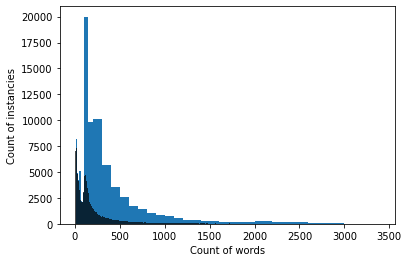

###################
length of longest sentence:  3239
length of shortest sentence:  0
average number of words in the sentence
32.08572629219778


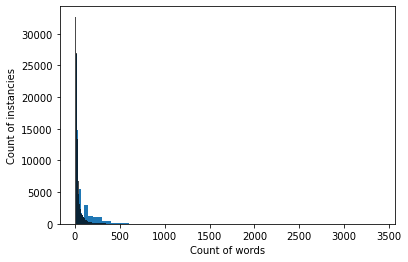

###################


In [43]:
f.simple_stat(train_sent)
f.simple_stat(train_set_clean)

In [34]:
def grammar_corrector(dictionary, text):
    cleaned_text = []
    for line in text:
        temp_line = []
        for word in line:
            temp_line.append(dictionary[word.lower()])
        cleaned_text.append(temp_line)
    return cleaned_text

In [35]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(spelling_dict.values())

In [36]:
# read the train data
data = train
train_sent = []
train_sentiment = []
train_idx = []
missing_indexies = []
y_train = []
length_of_sentencies_counter = []
for i in range(len(data)):
    try:
        train_sent.append(data[i]["reviewText"])
        train_sentiment.append(data[i]["sentiment"])
        train_idx.append(i)
        y_train.append(sent_dict[data[i]["sentiment"]])
        #length_of_sentencies_counter.append(len(data[i]["reviewText"].split()))
    except KeyError:
        missing_indexies.append(i)
        continue
print(missing_indexies)

########################## remove stop words delet missing shit 
##### ------------- remove stop words


train_set_clean, l = remove_stop_words(train_sent)
pre_tokenizer.fit_on_texts(train_set_clean)
print("Different words", max(pre_tokenizer.index_docs))
d = unknown_words_to_words(basic_dict)
# set of meaningfull words
s = set(d.values())
print("count of meaningful words", len(s))
# Get a list of words by count
basic_dict = {k: v for k, v in sorted(pre_tokenizer.word_counts.items(), key=lambda item: item[1])}
# convert into default dict to avoid error of missing words
basic_dict = defaultdict(int, basic_dict)
spelling_dict = unknown_words_to_words(basic_dict)


[4603, 4838, 16019, 18229, 19785, 23315, 28397, 28834, 33359, 43138, 43539, 43690, 44008, 44477, 44972, 48811, 49317, 50106, 51717, 52286, 55555, 56171, 57223, 58328, 58799, 58866, 59525, 59739, 61046, 61914, 61916, 62831, 63208, 72268, 78944, 79067, 80093, 80637, 80658, 81640, 81900, 82510, 83138, 83145, 83615, 84761, 87112, 88895, 88984, 89132, 91949, 94301, 94727, 99641]
Different words 68527
count of meaningful words 39275


length of longest sentence:  26544
length of shortest sentence:  1
average number of words in the sentence
257.3718207832229


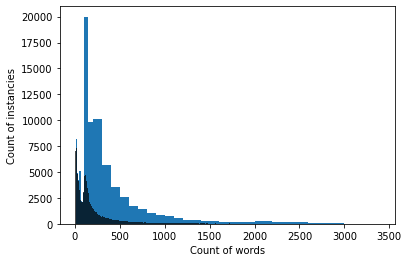

###################
length of longest sentence:  3239
length of shortest sentence:  0
average number of words in the sentence
32.08572629219778


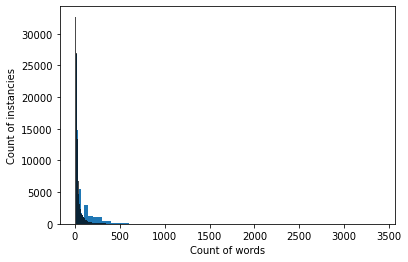

###################


In [37]:
f.simple_stat(train_sent)
f.simple_stat(train_set_clean)

In [38]:
data = dev
print(len(dev))
dev_sent = []
dev_sentiment = []
dev_idx = []
missing_indexies = []
dev_y_train = []
for i in range(len(data)):
    try:
        dev_sent.append(data[i]["reviewText"])
        dev_sentiment.append(data[i]["sentiment"])
        dev_idx.append(i)
        dev_y_train.append(sent_dict[data[i]["sentiment"]]) 
    except KeyError:
        missing_indexies.append(i)
        continue
print(missing_indexies)

# remove stop words
dev_sent, l = remove_stop_words(dev_sent)

########################## remove stop words delet missing shit 
##### ------------- remove stop words

print("##### ")
empties = []
for i in range(len(dev_sent)):
    if len(dev_sent[i]) == 0:
        empties.append(i)
c = 0
for i in empties:
    #print(train_sent[i-c])
    del dev_sent[i-c]
    del dev_sentiment[i-c]
    del dev_y_train[i-c]
    c += 1
    #print(c)
print(len(dev_sent))
print(len(dev_sentiment))
print(len(dev_y_train))

10000
[2900, 4294, 5135, 8540]
##### 
9984
9984
9984


In [39]:
data = test
test_sent = []
test_sentiment = []
test_idx = []
test_missing_indexies = []
#print(test)
for i in range(len(data)):
    try:
        test_sent.append(data[i]["reviewText"])
        test_sentiment.append(data[i]["sentiment"])
        #print(data[i]["sentiment"])
        test_idx.append(i)
        #y_train.append(sent_dict[data[i]["sentiment"]]) 
    except KeyError:
        test_missing_indexies.append(i)
        continue
print("index of reviews which are empty: ",test_missing_indexies)

# remove stop words
test_sent,l = remove_stop_words(test_sent)

index of reviews which are empty:  [90, 117, 439, 2138, 4112, 5364, 8210]


## New encoder

In [40]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(spelling_dict.values()) #words from the grammar correction to idx
#print("The document count",t.document_count)

In [41]:
Train = tokenizer.texts_to_sequences(grammar_corrector(spelling_dict,train_set_clean))
Dev = tokenizer.texts_to_sequences(grammar_corrector(spelling_dict,dev_sent))
Test = tokenizer.texts_to_sequences(grammar_corrector(spelling_dict,test_sent))

length of longest sentence:  2843
length of shortest sentence:  0
average number of words in the sentence
27.78763532307446


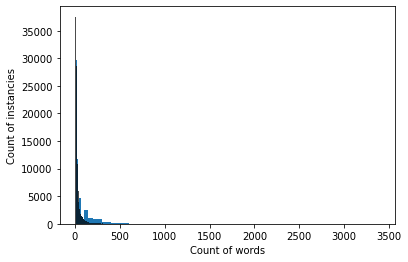

###################
length of longest sentence:  1175
length of shortest sentence:  0
average number of words in the sentence
25.73076923076923


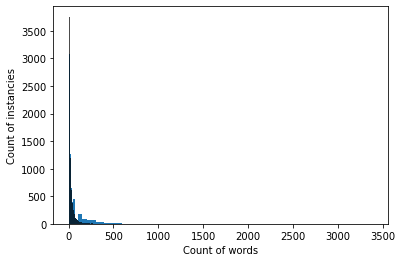

###################
length of longest sentence:  1110
length of shortest sentence:  0
average number of words in the sentence
23.19253477434204


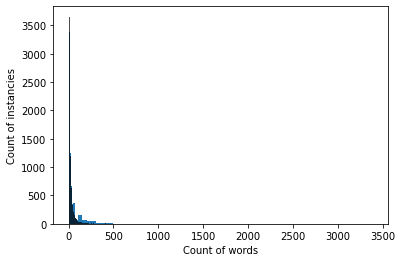

###################


In [42]:
f.simple_stat(Train)
f.simple_stat(Dev)
f.simple_stat(Test)

In [263]:
def sequence_pad(sequence, padding='pre', maxlen=50):
    res = tf.keras.preprocessing.sequence.pad_sequences(
        sequence,
        maxlen=maxlen,
        dtype='int32',
        padding=padding,
        truncating='pre',
        value=0.0)
    return res

In [276]:
len(X_train_p)

99946

## Padding the dataset, POST padding works better a little bit

In [287]:
padding = "post"
maxlen = 50 # how many words from the review
X_train_p = sequence_pad(Train, padding=padding, maxlen=maxlen)
X_dev_p = sequence_pad(Dev, padding=padding, maxlen=maxlen)
X_test_p = sequence_pad(Test, padding=padding, maxlen=maxlen)
len(X_train_p)

99946

In [289]:
X_train_m = np.array(X_train_p)
y_train_m = np.array(y_train)
print(len(y_train_m))
print(len(X_train_m))
X_valid_m = np.array(X_dev_p)
y_valid_m = np.array(dev_y_train)
print(len(X_valid_m))
print(len(y_valid_m))
X_test_m = np.array(X_test_p)
#y_test_m = np.array(y_test)
#print(len(X_test_m))
#print(len(y_test_m))

# sampling some random data for tran and DEV
random.seed(40)
bias = 20000

ran = random.randint(0, len(X_train_m)-bias)
ran_val = random.randint(0, len(X_valid_m)-(bias/10))
s_tr = ran
e = ran+bias
s_test = ran_val
e_test = ran_val+(bias/10)

X_train_m = X_train_m[s_tr:e]
y_train_m = y_train_m[s_tr:e]
#X_valid_m = X_valid_m[s_test:int(e_test)]
#y_valid_m = y_valid_m[s_test:int(e_test)]
#X_valid_m = X_valid_m[s:e]
#y_valid_m = y_valid_m[s:e]
print(len(y_train_m))
print(len(X_train_m))

99946
99946
9990
9990
20000
20000


# Early stopping Final

In [292]:
vocabulary_size = len(tokenizer.word_counts)

from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

# get time for saving the model

dateTimeObj = datetime.now()
save_time = str(dateTimeObj.year)+'-'+str(dateTimeObj.month)+'-'+str(dateTimeObj.day)+'-'+str(dateTimeObj.hour)+'-'+str(dateTimeObj.minute)+'-'+str(dateTimeObj.second)

# define the model

embedding_size=64
embedding_size=200 # bigger = slower train
model=Sequential()
model.add(Embedding(vocabulary_size+1, embedding_size, input_length=maxlen))
model.add(LSTM(100))
model.add(Dense(1, activation='tanh')) # shape of the labels, if its 2, than the y_ labels has a x* 2 shape 

model.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])

print(model.summary())

# early stopping

from keras.callbacks import ReduceLROnPlateau
earlyStopping = EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='min')
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=2, verbose=0, mode='min')
mcp_save = ModelCheckpoint('model/'+save_time+'-model.mdl_wts.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=1, verbose=1, mode='min') 
############x #factor for learning rate
# patience: 10% of number of epochs. Anyway, it is just for stopping the validation, since we have model checkpoint its doesnt matter
batch_size = 50 # lower = slower train, higher = faster train
num_epochs = 10

#X_valid, y_valid = X_train_k[batch_size:], y_train[batch_size:]
history = model.fit(X_train_m, y_train_m, validation_data=(X_valid_m, y_valid_m), 
                    batch_size=batch_size, 
                    epochs=num_epochs,
                   callbacks=[earlyStopping, mcp_save, reduce_lr_loss])  # for regularization)
#history = model.fit(X_train_m, y_train_m, batch_size=batch_size, epochs=num_epochs)
#model.fit(X_trainn, y_trainn, batch_size=batch_size, epochs=num_epochs)
#model.fit(X_train_m, y_train_m, batch_size=batch_size, epochs=num_epochs)
#mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
plt.plot(history.history["accuracy"], 'g--', label='train accuracy')
plt.plot(history.history["loss"], 'r--', label='train loss')
plt.plot(history.history["val_loss"], 'r:', label='validation loss')
plt.plot(history.history["val_accuracy"], 'g:', label='validation accuracy')
plt.legend()
plt.show()
######### ------------------------- ################### save the model
#model.save('model/'+save_time)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 200)           7854800   
                                                                 
 lstm_5 (LSTM)               (None, 100)               120400    
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 7,975,301
Trainable params: 7,975,301
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
400/400 [==============================] - 64s 157ms/step - loss: 0.7270 - accuracy: 0.7065 - val_loss: 0.5204 - val_accuracy: 0.8065 - lr: 0.0010
Epoch 2/10
400/400 [==============================] - ETA: 0s - loss: 0.3316 - accuracy: 0.8816
Epoch 2: ReduceLROnPlateau reducing learning rate

KeyboardInterrupt: 

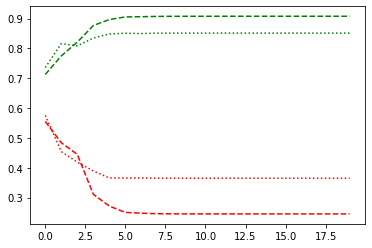

In [293]:
plt.plot(history.history["accuracy"], 'g--', label='train accuracy')
plt.plot(history.history["loss"], 'r--', label='train loss')
plt.plot(history.history["val_loss"], 'r:', label='validation loss')
plt.plot(history.history["val_accuracy"], 'g:', label='validation accuracy')

In [37]:
model.save('model/'+save_time)

INFO:tensorflow:Assets written to: model/2022-4-18-23-34-42\assets


INFO:tensorflow:Assets written to: model/2022-4-18-23-34-42\assets


## Result

In [24]:
#model.save('model/'+save_time)
model = keras.models.load_model('model/'+save_time+'-model.mdl_wts.hdf5')
result = np.round(model.predict(X_valid_m))
accuracy_score(y_valid_m, result)

0.9009415064102564

## Sentiment results, Sampling some guess

In [32]:
prediction = np.round(model.predict(X_test_p))

In [34]:
acc = 0
acc_count = 0
res_final = []
for r in prediction:
    acc_count+=1
    if r==0:
        res_final.append("negative")
    if r==1:
        res_final.append("positive")
        
for i in random.sample(range(0, 9993), 5):
    print("index", i)
    print("####", res_final[i], "---", test_sent[i])

index 8758
#### positive --- ['I', 'love', 'song', '.', 'Can', 'understand', 'isn', 'getting', 'airplay', '.']
index 4368
#### positive --- ['Great', '!']
index 9359
#### negative --- ['Horrible']
index 167
#### positive --- ['I', 'heard', 'song', 'concert', 'determined', 'collection', '.', 'It', 'beautiful', 'relaxing', 'great', 'song', 'come', 'home', 'listen', 'work', '.']
index 5115
#### positive --- ['I', 'saw', 'On', 'Road', 'I', 'LOVED', 'music', '.', 'I', 'thought', 'represented', 'phase', 'early', 'upbeat', 'jazz', 'I', 'unfamiliar', 'really', 'liked', 'lot', '.', 'Ironically', 'I', 'found', 'early', 'jazz', 'I', 'thought', 'I', 'loved', 'album', 'actually', 'modern', 'compositions', 'Gustavo', 'Santaolalla', 'modern', 'soundtrack', 'guy', 'even', 'read', 'music', 'supposedly', '!', 'Great', 'album', 'parties', '.']


In [35]:
from collections import defaultdict

json_raw_data = []
jsonfilename = 'dataset/classification/tt.gz'
counter = 0
list_of_skip_indexies = [90, 117, 439, 2138, 4112, 5364, 8210]
res_count = 0
for line in gzip.open('dataset/classification/t_masked.gz'):
    review_data = json.loads(line)
    tempdata = []
    if counter in list_of_skip_indexies: # keep origin
        print("keep original")
        print(counter)
        print(review_data)
        res_count -=1
        for key in review_data:
            #print("keep original")
            tempdata.append({
            key: str(review_data[key])})
    else:
        def_dict = defaultdict(list)
        def_dict = dict()
        for key in review_data:
            #print(key)
            if key == "sentiment":
                def_dict[key] = res_final[res_count]
            else:
                tempdata.append({
                key: str(review_data[key])})
                def_dict[key] = str(review_data[key])
    counter += 1
    res_count +=1
    #print(counter)

    #json_raw_data.append(def_dict)
    json_raw_data.append(def_dict) # ok this is very good, itsa opening with json.load
    
outFile = open('music_reviews_test.json', 'w')
for instance in json_raw_data:
      outFile.write(json.dumps(instance) + '\n')
outFile.close()

keep original
90
{'verified': False, 'reviewTime': '11 16, 2015', 'reviewerID': 'A1O7C6DFZ15E43', 'asin': 'B007Z2OQB0', 'summary': 'Five Stars', 'unixReviewTime': 1447632000, 'sentiment': '_', 'id': 90}
keep original
117
{'verified': True, 'reviewTime': '07 31, 2017', 'reviewerID': 'AWGJYHMXOYCVI', 'asin': 'B007ZCH8R4', 'unixReviewTime': 1501459200, 'sentiment': '_', 'id': 117}
keep original
439
{'verified': True, 'reviewTime': '08 16, 2016', 'reviewerID': 'A24YYQXR82CKHJ', 'asin': 'B008591TBW', 'style': {'Format:': ' MP3 Music'}, 'summary': 'Five Stars', 'unixReviewTime': 1471305600, 'sentiment': '_', 'id': 439}
keep original
2138
{'verified': True, 'reviewTime': '09 13, 2016', 'reviewerID': 'A1ZBIIZLWE8NRE', 'asin': 'B00940XFTK', 'style': {'Format:': ' MP3 Music'}, 'summary': 'Five Stars', 'unixReviewTime': 1473724800, 'sentiment': '_', 'id': 2138}
keep original
4112
{'verified': True, 'reviewTime': '07 4, 2018', 'reviewerID': 'A1K51YDXUGEEBG', 'asin': 'B000YIWSK8', 'unixReviewTime':

In [36]:
for line in gzip.open('group16.json.gz'):
    review_data = json.loads(line)
    for key in review_data:
        print('"' + key +'": ' + str(review_data[key]))
    break

FileNotFoundError: [Errno 2] No such file or directory: 'group16.json.gz'